# Reddit Stock Subreddit Analysis
## by Scott Levin
### February, 2018

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from PIL import Image
from wordcloud import WordCloud
%matplotlib inline

The data was scraped using PRAW

In [3]:
df = pd.read_csv('stocks_from_sep.csv', index_col=0)

In [4]:
#Creating a variable for the length of the title (number of characters). 
df['Length'] = df['title'].apply(len)

In [5]:
#Identifying the median value to use as the response value and creating this column as a dummy variable. 
df['number_of_comments'].median()
df['median_com'] = (df['number_of_comments'] > 6).astype(int)

In [6]:
df.head()

,date_created,is_video,number_of_comments,title,up_votes,Length,median_com
0,2018-02-19 16:14:30,False,2,A Natural monopoly stock - growth question.,1,43,0
1,2018-02-19 15:07:47,False,0,Fund changing from Close end to Open end. Effe...,2,50,0
2,2018-02-19 12:41:08,False,6,AbbVie (ABBV),21,13,0
3,2018-02-19 08:36:12,False,0,Weekly Trade Update for Feb-16-2018,0,35,0
4,2018-02-19 08:13:34,False,3,Is this a good/bad deal? Offered shares at the...,4,75,0


In [7]:
#Gathering all string data from the title variable into one long string. 
txt = ''
for val in df['title']:
    txt = txt + ' ' + val

In [8]:
#There are 1287 digit values in the titles, or roughly 31 'words' for every numerical value in a title. 
tokenizer = RegexpTokenizer(r'\d+')
tokens = tokenizer.tokenize(txt)
len(tokens)

1287

In [9]:
#Second, I want to understand the overall makeup of the title texts. Initially looking only at word values. 
#Only 14% of words are unique.
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(txt.lower())
len(set(tokens))/len(tokens)
len(tokens)/1287

30.954156954156954

In [10]:
#creating a dummy variable if the title contains a numeric character. 
nums = []
for val in df['title']:
    p = re.findall(r'\d+', val)
    if p:
        nums.append(1)
    else:
        nums.append(0)
df['contains_num'] = nums

In [11]:
#There are no video posts for this subreddit, dropping these values. 
df = df.drop('is_video', axis=1)

In [12]:
#Initializing lemmatizer 
lemmatizer = WordNetLemmatizer()
# stopwords = stopwords.words('english')
# stopwords += 'would'  #Think about adding 'would'
def cleaner(title):
    """ This function accepts a string, tokenizes it, removes stopwords,
    lemmatizes them, and then return the words as a joined string"""
    tokenizer = RegexpTokenizer(r'\w+')
    no_chars = re.sub(r"[^a-zA-Z]", " ", title)
    titles = tokenizer.tokenize(no_chars.lower())
    lst = [word for word in titles if word not in set(stopwords.words('english')) and len(word) > 1]
    lemons = [lemmatizer.lemmatize(word) for word in lst]
    final = ' '.join(lemons)
    return final

df['tokens'] = df['title'].apply(cleaner)

In [14]:
df['date_created'] = pd.to_datetime(df['date_created'])

### Transforming titles into features with countvectorizer

In [15]:
cvec = CountVectorizer()
cvec.fit(df['tokens'])
cvecdata = cvec.transform(df['tokens'])

In [16]:
feature_df = pd.DataFrame(cvecdata.todense(), 
                           columns=cvec.get_feature_names())

### What are the 10 most common title words? 

In [17]:
feature_df.T.sum(axis=1).sort_values(ascending=False).head(10)

stock       1182
thought      353
buy          290
market       268
good         193
company      174
question     174
long         156
earnings     153
etf          149
dtype: int64

### What about the sparsity? Only 0.087% of values are non-zero. 

In [18]:
sparsity = (100 * feature_df.astype(bool).sum(axis=0).sum() / 
            (feature_df.shape[0] * feature_df.shape[1]))
print('Sparsity: ', sparsity)

Sparsity:  0.0872874922691


### Without any further cleaning/parameters, how accurately can we predict 'popular' reddit posts using only word frequencies in logistic regression?

In [19]:
def logreg(X, y):
    
    """A basic logistic regression function, prints accuracy score and
    a simple confusion matrix, returns the train/test sets and model"""
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=42)

    lr = LogisticRegression()
    
    lr.fit(X_train, y_train)
    
    predictions = lr.predict(X_test)
    
    print(pd.crosstab(y_test, predictions, rownames=['Actual'], 
                           colnames=['Predicted'], margins=True), '\n')
    print('Overall accuracy:', accuracy_score(y_test, predictions))
    
    return X_train, X_test, y_train, y_test, lr

In [20]:
X = feature_df.copy()
y = df.median_com

X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1   All
Actual                   
0          561  268   829
1          315  526   841
All        876  794  1670 

Overall accuracy: 0.650898203593


### Now let's take a look at the most important 'word features'...

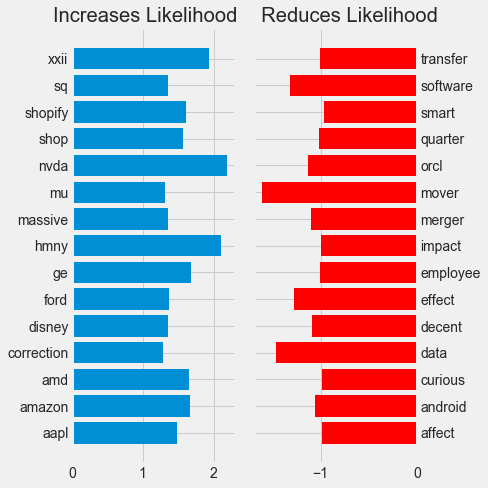

In [21]:
test_df = pd.DataFrame(lr.coef_[0], index=X_train.columns, 
                       columns=['coefficients'])

important_vars = pd.DataFrame(test_df['coefficients'].sort_values(
                    ascending=False).head(15)).reset_index()

important_vars2 = pd.DataFrame(test_df['coefficients'].sort_values(
                                            ).head(15)).reset_index()

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(ncols=2, figsize=(7, 7))

axes[0].barh(important_vars['index'], important_vars['coefficients'], 
             align='center')
axes[1].barh(important_vars2['index'], important_vars2['coefficients']
             , align='center',color='red')

axes[1].yaxis.tick_right()
axes[0].set(title='Increases Likelihood   ')
axes[1].set(title='     Reduces Likelihood')

plt.rcParams.update({'font.size': 14})
plt.tight_layout()

### Many of these are stock labels: 

    * xxii = 22nd century group  * ge = General Electric
    * sq = Square inc.           * amd = Advanced Micro Devices
    * aapl = Apple               * hmny = Helios and Matheson Analytics 
    * nvda = Nvidia              * orcl = Oracle

### What if we do the same thing, but add in a few additional features?

In [22]:
X = pd.concat([feature_df, df[['Length', 'contains_num']]], axis=1)
y = df.median_com

X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1   All
Actual                   
0          565  264   829
1          306  535   841
All        871  799  1670 

Overall accuracy: 0.658682634731


### Less than a 1% improvement... Perhaps there is too much noise? 
How much do these variables explain on their own? 

In [23]:
#Dropped 'contains a number' because it was statistically insignificant.
#Of cou
X = df[['Length', 'contains_num']]
y = df.median_com

X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted     0    1   All
Actual                    
0           615  214   829
1           556  285   841
All        1171  499  1670 

Overall accuracy: 0.538922155689


Correlation between Length/Up_Votes:  
 0.117837598393
Correlation between Median_Comments/Up_Votes:  
 0.243566459137
Correlation between Median_Comments/Contains_Number:  
 0.0723432056072
Correlation between Median_Comments/Length:  
 0.0636586441287


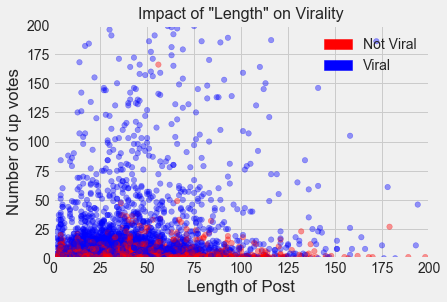

In [24]:
color_map = {1: 'b', 0:'r'}
fig, ax = plt.subplots()
ax.scatter(df['Length'], df['up_votes'], 
           c=[color_map[i] for i in df['median_com']], alpha=0.4,s=30)
ax.set_ylim(0, 200)
ax.set_xlim(0, 200)
legend_patch = mpatches.Patch(color='red', label='Not Viral')
legend_patch2 = mpatches.Patch(color='blue', label='Viral')                            
plt.legend(handles=[legend_patch, legend_patch2])
ax.set_xlabel('Length of Post')
ax.set_ylabel('Number of up votes')
ax.set_title('Impact of "Length" on Virality', fontdict={'fontsize': 16})

print('Correlation between Length/Up_Votes: ', '\n', 
      np.corrcoef(df['Length'].values, df['up_votes'].values)[0][1])
print('Correlation between Median_Comments/Up_Votes: ', '\n', 
      np.corrcoef(df['median_com'].values, df['up_votes'].values)[0][1])
print('Correlation between Median_Comments/Contains_Number: ', '\n', 
      np.corrcoef(df['median_com'].values, df['contains_num'].values)[0][1])
print('Correlation between Median_Comments/Length: ', '\n', 
      np.corrcoef(df['median_com'].values, df['Length'].values)[0][1])

Text(0.5,1,"Length's Effect on Virality")

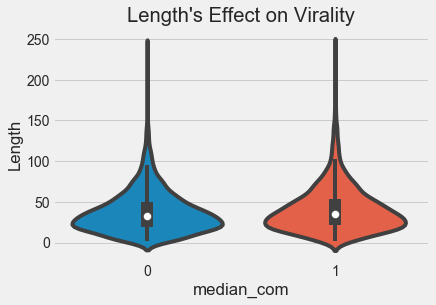

In [25]:
fig, ax = plt.subplots()
sns.violinplot(df.median_com, df.Length, )
ax.set_title('Length\'s Effect on Virality')

### K-nearest Neighbors accurate predicted ~54% of values correctly

In [26]:
X = feature_df
y = df.median_com
    
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                            test_size=0.3, random_state=42)

knn5 = KNeighborsClassifier(n_neighbors=10)
knn5.fit(X_train, y_train)
predictions = knn5.predict(X_test)
print(accuracy_score(y_test, predictions))

0.538323353293


In [27]:
svm = SVC()

svm.fit(X_train, y_train)
predictions = svm.predict(X_test)
accuracy_score(y_test, predictions)

0.49640718562874253

In [28]:
tdif = TfidfTransformer()
X = tdif.fit_transform(feature_df)

In [29]:
X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1   All
Actual                   
0          592  237   829
1          328  513   841
All        920  750  1670 

Overall accuracy: 0.661676646707


In [30]:
new = pd.DataFrame(X.todense(), columns=feature_df.columns)
word_values = new.sum(axis=0).sort_values(ascending=False).reset_index().T
word_values.columns = word_values.iloc[0, :]
word_values = word_values.drop('index', axis=0)
#dropping 30% of the columns by Tfid weight
best_words = word_values.iloc[:, :int((4803 * .7))]

In [31]:
#Merging the useful words onto the Tfid data frame
new_df = pd.DataFrame(X.todense(), columns=feature_df.columns)
X = new_df[list(best_words.columns)]
X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1   All
Actual                   
0          594  235   829
1          331  510   841
All        925  745  1670 

Overall accuracy: 0.661077844311


### What happens when you widen the gap for the median? i.e. eliminate observations close to the boundry (6) . There is likely little difference in the title of a post that recieves 6 vs. 7 comments... 

In [32]:
#I have 5566 observations, 1335 observations have 0, 1 or 2 comments.
len(df.loc[(df.number_of_comments.isin([0,1, 2]))])
len(df.loc[(df.number_of_comments > 8)])

sep_df = df.loc[(df.number_of_comments < 3) | (df.number_of_comments > 13)]

#The classes are now separated (no values between 2 and 14)
sep_df['median_com'].value_counts()

1    1492
0    1335
Name: median_com, dtype: int64

In [33]:
#Not surprisingly- creating a larger gap between the # of comments allows
#for improved accuracy. 
cvec = CountVectorizer()
cvecdata = cvec.fit_transform(sep_df['tokens'])
X = pd.DataFrame(cvecdata.todense(), columns=cvec.get_feature_names())
y = sep_df['median_com']

X_train, X_test, y_train, y_test, lr = logreg(X, y)

Predicted    0    1  All
Actual                  
0          277  137  414
1           92  343  435
All        369  480  849 

Overall accuracy: 0.730270906949


### How many words are common between viral/not viral titles? 

In [60]:
#Getting the most common words from 'viral' titles
from collections import Counter
tokenizer = RegexpTokenizer(r'\w+')
words = list(sep_df.loc[sep_df['median_com'] == 1]['tokens'].values)
blanks = []
for word in words:
    blanks.extend(tokenizer.tokenize(word))
common_viral = Counter(blanks).most_common(100)
common_viral = [word[0] for word in common_viral]

In [61]:
#Getting most common words from not 'viral' titles
words = list(sep_df.loc[sep_df['median_com'] == 0]['tokens'].values)
blanks = []
for word in words:
    blanks.extend(tokenizer.tokenize(word))
not_viral = Counter(blanks).most_common(100)
not_viral = [word[0] for word in not_viral]

### Of the 100 most common words in each set, 53 are common to both! 

In [104]:
unique_not_viral = [word for word in not_viral if not word in common_viral]
unique_viral = [word for word in common_viral if not word in not_viral]
common_both = [word for word in common_viral if word in not_viral]
len(unique_not_viral)

47

### Let's look at a cool visualization of the word differences and similarities...

In [133]:
def word_image(list_of_words, file_loc, title, scale1, scale2):
   
    """Creates a word cloud with a particular image in a grey scale"""
    
    def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
        return "hsl(600, 0%%, %d%%)" % np.random.randint(scale1, scale2)

    mask = np.array(Image.open(file_loc))
    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(mask=mask, background_color='white').generate(' '.join(
                                [word for word in list_of_words]))
    
    plt.imshow(wordcloud.recolor(color_func=grey_color_func), interpolation='bilinear')
    plt.title(title, fontdict={'fontsize': 30})
    plt.axis('off')

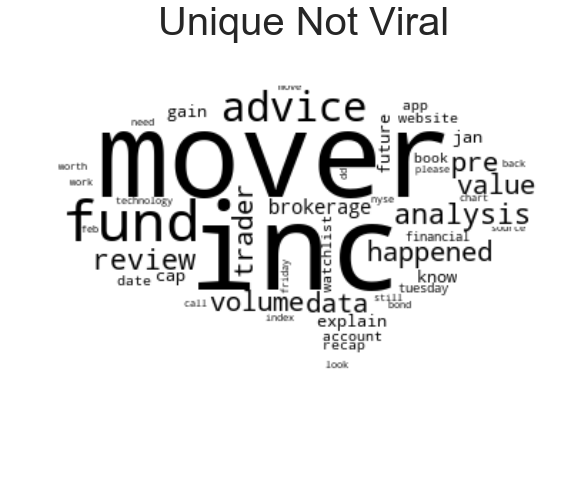

In [137]:
word_image(unique_not,'./outline.png', 'Unique Not Viral', 0, 4)

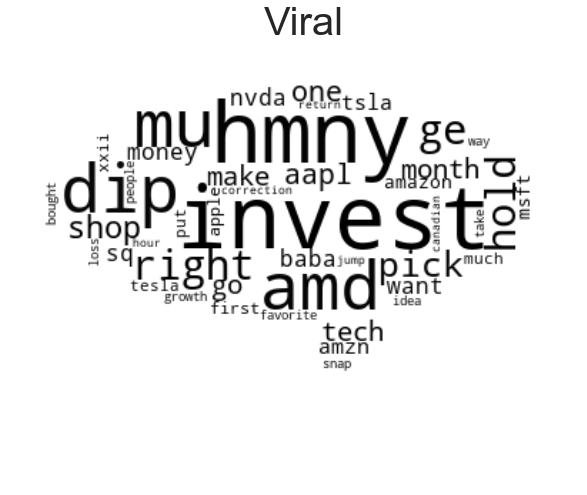

In [138]:
word_image(unique_viral,'./outline.png', 'Viral', 0, 4 )

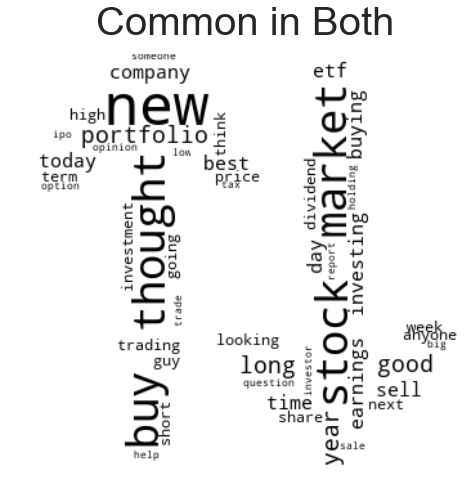

In [139]:
word_image(common_both, './arrow2.jpg', 'Common in Both', 0, 4)